### Test curvature calculations ###

In [1]:
import subprocess, shutil, datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import vtu
from vtu import PyVtu
from ts_auto_wrapper import TSWrapper

In [2]:
ts=TSWrapper(Path("/opt/workspace/msc_project/cluster-trisurf"))
trisurf_test = Path('/opt/workspace/msc_project/simulations'
                    '/QA_tests/cluster_version/rework')

In [3]:
# children = lambda path: list(sorted(path.iterdir()))
# children(trisurf_test)

In [4]:
test_folder = trisurf_test/'egg_carton'
tape=None
extra_args = []
destroy_timesteps_at_end=False # destroy all timesteps after the test
timeout = 1000 # seconds to timeout for each `trisurf` test

In [5]:
tape = """
##################
## Trisurf Tape ##
##################

# a control file for the trisurf simulations
# $ are program control
# * are initialization only

####### Vesicle definitions ###########
# * nshell is a number of divisions of dipyramid
nshell=20
# $ dmax is the max. bond length (in units l_min)
dmax=1.7
# $ dmin_interspecies in the min. dist. between different vertex species (in units l_min)
dmin_interspecies=1.2
# $ max step size (in units l_min)
stepsize=0.15


#######  Cell definitions ############
# $ partition space to cells of 
nxmax=100
nymax=100
nzmax=100


####### Program Control ############
# $ how many MC sweeps between subsequent records of states to disk. 200000 is reasonable value
mcsweeps=1000
# $ how many initial mcsweeps*inititer MC sweeps before recording to disk?
inititer=0
# $ how many records do you want on the disk iteration are there in a run?
iterations=10


# $ do not write "ts_fprintf" statesments to stdout (for use in cluster)
quiet=false


######-----------------------------#######
###### Memrbane and CMC properties #######
######-----------------------------#######

# * bending rigidity of the membrane (in units kT)
xk0=20
# * xk2: Gaussian bending modulus
xk2=-20

# Each vertex is associated with a type (8 bit flag):
#   0x01 : bonding vertex              0x02 : active force vertex
#   0x04 : adhesive vertex             0x08 : anisotropic vertex
#   0x10 : (reserved for future use)   0x20 : vicsek vertex (correlated force)
#   0x40 : edge vertex (not used)      0x80 : ghost vertex (unnmoving) (must be ==type!)
#   Bare membrane vertices (default) are adhesive 0x04 (4), 
# CMC vertices are bonding, active, anisotropic, and correlated 0x2F (47)
# * number of CMC vertices (integer)
number_of_vertices_with_c0=0
# * c0/2 is spontaneous curvature. c0 is used as (c1+c1-c0)^2 in energy term (float)
c0=0.5
# * d0/2 is spontaneous deviator. d0 is used in shape tensor only (float)
# Mismatch = Curvature - c0/2*I - d0/2 sigma_z (i.e. the 1st and 2nd intrinsic curvatures are half the sum and half the difference )
d0=0.5

# $ curvature model (8 bit flag)
#   0x01 : calculate angle-sum gaussian curvature,  0x02 : calculate shape operator, 
#   0x04 : update director even in the old method.  0x08 : use shape operator energy rather than just save it
#   0x10 : use shape, but only for anisotropic.     0x20 : do not rotate director as a MC step
#   0x40 : disable old method (use shape op only)   0x80 : calculate angle sum only if kx2!=0
# example of important models: 
# 0: old method. 7: debug, save everything but use energy from old method. 35: parallel transport of directors only
curvature_model=15
# $ limit sharp edges by imposing the dihedral angle between triangle obeys cos(phi_ab)>X. -1 means no limit
min_dihedral_angle_cosine=0.1

# * energy of bond between bonding vertices (float, positive value for attraction)
w=1.0
# $ bond model- vertex of bonding type bind with mean(w). (flag)
# 0x1: require type identity.   0x2: nematic interaction between anisotropic vtx
bond_model=0

# * direct force on active vertices (float)
F=1.0
# $ force_model- force on active type vertices. (integer flag)
#   0: force in normal direction
#   1: F proportional nonactive neigh, 2: F proportional nonconcave neigh
#   3: F=0 if any neigh is concave
#   16: Vicsek, direction aligend with connected neighbors up to radius,
#   17: 16, with weight 1/neighbor accoding to distance
force_model=0
# $ Vicsek: force direction is sum of own normal + (nearest neighbor normals * vicsek_strength)
# interaction strength parameter: Vicsek: weight of neighbors (float)
vicsek_strength=0.1
# $ interaction radius parameter: Vicsek: max. neighbor distance (integer)
vicsek_radius=4.0


######---------------------#######
###### Adhesion to surface #######
######---------------------#######

# $ Adhesion model (8 bit flag)
# energy of any adhesive vertex dx distance from the adhesion geometry 
# as long as distance is less than the cutoff (dx0)
#   0x01: step potential ad_w*(dx/dx0), 
#   0x02: parabolic ad_w*(1-(dx/dx0)^2)
#   0x04: y-anisotropy factor *exp(-y/scale)
adhesion_model=1
# $ type of adhesion geometry do you want (integer flag)
#   1: plane surface               f(r)=z-z0
#   2: spherical surface           f(r)=(x**2 + y**2 + (z-z0)**2)-r**2
#   3: cylindrical surface         f(r)=((z-z0)**2 + x**2)-r**2
#   4: plane-x sinosoidal surface    f(r)=z-(z0+rcos(x))
#   5: plane surface with adhesion spots  E*=factor*([x/scale-0.5]**2+[y/scale - 0.5]**2 less than r**2)
#   6: plane-xy sinosoidal surface    f(r)=z-(z0+rcos(x)cos(y))
adhesion_geometry=6
# $ potential range (float in lmin)
adhesion_cutoff=1
# $ position of the adhesive surface (float)
# bipyramid topmost is approx. z_max = 0.630877*nshell, so -z_max is a good guess
adhesion_z=-10
# $ radius of the sphere or cylinder.
adhesion_radius=2.0
# $ for sinosoidal, adhesion spot lattice, and y anisotropy (float)
adhesion_scale=2.0
# $ factor of adhesion on spots (float)
adhesion_factor=2.0
# * adhesion energy per vertex (float)
adhesion_strength=4.0

# $ Allow motion of center mass: default (0) reset vesicle to 0,0,0 every few time steps (bool) 
allow_center_mass_movement=0
# $ In active case, we need to apply an external force in the z-direction for overall force balance along z-direction, choose 1 if you want this, 0 otherwise (bool)
force_balance_along_z_axis=0


######-------------------------------------------#######
###### Pressure/volume/area/tension calculations #######
######-------------------------------------------#######

# all of these are program control (# $)

# $ Calculate p*dV energy contribution (bool)
pressure_switch=0
# $ pressure difference: p_inside - p_outside (in units kT/l_min^3):
pressure=0.0

# $ Volume constraint/energy (integer flag) 
#   0: disable constant volume
#   1: enable with additional vertex move {broken}
#   2: enable with epsvol range
#   3: enable parabolic potential (xkV0/2V0 (V-V0)^2)
#   4: enable reduced volume parabolic potential (xkV0/2 (V_red_eq-V/Vsph)^2)
volume_switch=0
constvolprecision=1e-14
# $ Rest volume. Set V0 less than 1 to determine volume from initial conditions (see constant_volume tag in .vtu files) (float)
V0=0
# $ volume modulus (float)
# needs some thinking: reasonable values depends on number of vertices N!
# reduced volume scaling is between 1/(N Sqrt(N)) and 1/N
xkV0=1.0
# $ reduce volume at equilibrium (between 0 and 1) (float)
Vr=1.0

# $ Area constraint/energy (integer flag) 
#   0: disable constant area, 
#   1: stretching of triangles
#   2: enable constant area with epsarea
#   3: enable parabolic potential (xkA0/2A0 (A-A0)^2)
area_switch=0
# $ Rest area, A0 less than 1 to determine area from initial conditions (see constant_area tag in .vtu files)  (float)
A0=0
# $ Stretching modulus (float)
xkA0=1.0


######------######
###### misc ######
######------######

####### Nucleus (inside the vesicle) ###########

# $ Radius and $ position of an impenetrable hard sphere inside the vesicle (float)
R_nucleus=0
R_nucleusX=0
R_nucleusY=0
R_nucleusZ=0

###### Plane confinement ############

# $ plane confinement; two plates between the substrate-vesicle system, upper plate in moving downwards untill plan_d, lower plate is stationary
plane_confinement_switch=0
# $ final plane distance (float in lmin)
plane_d=10
# $ plane to vesicle repulsion force while closing
plane_F=1.0

###### Spherical harmonics ###########

# $ If 0 then spherical harmonics are not calculated at all. (integer)
spherical_harmonics_coefficients=0


#####----------------------------------######
##### Polymer and filament decorations ######
#####----------------------------------######

####### Polymer (brush) definitions ###########
# * npoly is a number of polymers attached to npoly distinct vertices on vesicle
npoly=0
# * nmono is a number of monomers in each polymer
nmono=20
# $ Spring constant between monomers of the polymer
k_spring=800
# * set to 1 if half of the polymeres are inside the vesicle
internal_poly=0

####### Filament (inside the vesicle) definitions ###########
# * nfil is a number of filaments inside the vesicle
nfil=0
# * nfono is a number of monomers in each filament
nfono=3
# $ Persistence lenght of the filaments (in units l_min)
xi=100

##### no multiprocessing #######

"""

In [6]:
raise RuntimeError("Are you sure you want to re-run trisurf? if not, skip this chunk")

RuntimeError: Are you sure you want to re-run trisurf? if not, skip this chunk

### Make a new folder if there isn't one ###

In [27]:
new_folder=None
if not test_folder:
    # make up some appropriate folder
    now = datetime.datetime.now()
    ret = subprocess.run(['git', 'status'],cwd=ts.path_to_trisurf,capture_output=True)
    branch = ret.stdout.decode().partition('On branch ')[-1].splitlines()[0].strip()
    new_folder = f'{now.year:04}_{now.month:02}_{now.day:02}_{branch}'
    test_folder = trisurf_test/new_folder
new_folder

In [28]:
if not test_folder.exists():
    test_folder.mkdir()
    test_folder.joinpath('test_results').mkdir()
elif new_folder is not None:
    raise ValueError(f'folder {test_folder} for today already exists: Rename or delete to run test')

### copy the tape to the new folder ###

In [29]:
if tape is None:
    shutil.copy(ts.path_to_trisurf/"src/tape",test_folder/"tape")
if type(tape) is str:
    with open(test_folder/"tape",'w') as f: f.write(tape);
else:
    shutil.copy(tape,test_folder/"tape")

## Check force from tape ##

In [30]:
ret = subprocess.run([ts.path_to_trisurf/"src/trisurf", "--force-from-tape", *extra_args],
                     cwd=test_folder, timeout=timeout, capture_output=True)

In [31]:
with open(test_folder/"test_results"/"force_stdout.txt",'w') as f: 
    f.write(ret.stdout.decode()+'\n'+ret.stderr.decode())
shutil.copy(test_folder/"statistics.csv",test_folder/"test_results"/"force_statistics.csv")
print(ret.stdout.decode())

[2023-05-29 16:01:21] TRISURF-NG v. 24764b9, compiled on: May 29 2023 15:25:02.
[2023-05-29 16:01:21] Programming done by: Samo Penic and Miha Fosnaric
[2023-05-29 16:01:21] Released under terms of GPLv3
[2023-05-29 16:01:21] Starting program...

[2023-05-29 16:01:21] ************************************************
[2023-05-29 16:01:21] **** Generating initial geometry from tape *****
[2023-05-29 16:01:21] ************************************************

[2023-05-29 16:01:21] Starting initial_distribution on vesicle with 20 shells!...
[2023-05-29 16:01:22] initial_distribution finished!
[2023-05-29 16:01:22] using debug curvature model 15 (use new energy): set to 7 to use the old energy method
[2023-05-29 16:01:22] simulation seed 1685365282
[2023-05-29 16:01:22] Setting volume V0=8335.95031008003388706
[2023-05-29 16:01:22] Setting area A0=2494.15316289923475779
[2023-05-29 16:01:32] Done 1 out of 10 iterations (x 1000 MC sweeps).
[2023-05-29 16:01:43] Done 2 out of 10 iterations (x

In [34]:
ret = subprocess.run([ts.path_to_trisurf/"src/trisurf", '-c iterations=150',*extra_args],
                     cwd=test_folder, timeout=10*timeout, capture_output=True)

In [35]:
with open(test_folder/"test_results"/"continute2_stdout.txt",'w') as f: 
    f.write(ret.stdout.decode()+'\n'+ret.stderr.decode())
shutil.copy(test_folder/"statistics.csv",test_folder/"test_results"/"continute2_statistics.csv")
print(ret.stdout.decode())

[2023-05-29 16:13:18] TRISURF-NG v. 24764b9, compiled on: May 29 2023 15:25:02.
[2023-05-29 16:13:18] Programming done by: Samo Penic and Miha Fosnaric
[2023-05-29 16:13:18] Released under terms of GPLv3
[2023-05-29 16:13:18] Starting program...

[2023-05-29 16:13:18] **********************************************************************
[2023-05-29 16:13:18] **** Recreating vesicle from dump file and continuing simulation *****
[2023-05-29 16:13:18] **********************************************************************

[2023-05-29 16:13:18] using debug curvature model 15 (use new energy): set to 7 to use the old energy method
[2023-05-29 16:13:18] simulation seed 1685365998
[2023-05-29 16:13:18] Setting volume V0=13701.25434041755761427
[2023-05-29 16:13:18] Setting area A0=2982.33844155898896133
[2023-05-29 16:13:27] Done 51 out of 150 iterations (x 1000 MC sweeps).
[2023-05-29 16:13:37] Done 52 out of 150 iterations (x 1000 MC sweeps).
[2023-05-29 16:13:47] Done 53 out of 150 itera

## Test curvature of Egg carton

In [52]:
fileloc = list(sorted(test_folder.glob('timestep*')))[-1]

In [53]:
fileloc

PosixPath('/opt/workspace/msc_project/simulations/QA_tests/cluster_version/rework/egg_carton/timestep_000174.vtu')

In [54]:
vesicle = ts.parseDump(fileloc)

In [55]:
v = PyVtu(fileloc)
v2 = PyVtu(fileloc) # we will place here the values from vesicle

In [56]:
def iter_xlist(vesiclePtr,xlist_name='vlist',as_pointer=False):
    """Iterate over some vesicle->xlist->xs. Default vesicle->vlist->vtx[:vlist.n]."""
    lst = vesiclePtr.contents.__getattribute__(xlist_name)
    if xlist_name=='vlist':
        n, lst = lst.contents.n, lst.contents.vtx
    elif xlist_name=='clist':
        n, lst = lst.contents.cellno, lst.contents.cell
    elif xlist_name=='tlist':
        n, lst = lst.contents.n, lst.contents.tria
    elif xlist_name=='blist':
        n, lst = lst.contents.n, lst.contents.bond
    else:
        raise ValueError(f'{xlist_name} not in vlist,clist,tlist,blist')
    if as_pointer:
        for i in range(n):
            yield lst[i]
    else:
        for i in range(n):
            yield lst[i].contents

In [57]:
def replace_pyvtu_values_from_vesicle(v,vesiclePtr):
    """Replace the values the PyVtu arrays with values from the wrapper."""
    blen = vesicle.contents.blist.contents.n
    tlen = vesicle.contents.tlist.contents.n
    v.pos[:] = [(x.x,x.y,x.z) for x in iter_xlist(vesicle)]
    v.add_array('neigh_no',np.array([x.neigh_no for x in iter_xlist(vesicle)]))
    v.c0[:] = [x.c for x in iter_xlist(vesicle)]
    v.e[:] = [x.energy for x in iter_xlist(vesicle)]
    # newer version stuff (can fail but who cares?)
    v.w[:] = [x.w for x in iter_xlist(vesicle)]
    v.f0[:] = [x.f for x in iter_xlist(vesicle)]
    v.face_normal[-tlen:] = np.array([(x.xnorm, x.ynorm, x.znorm) for x in iter_xlist(vesicle,"tlist")])
    v.normal[:] = [(x.nx,x.ny,x.nz) for x in iter_xlist(vesicle)]
    v.force[:] =[(x.fx,x.fy,x.fz) for x in iter_xlist(vesicle)]
    v.director[:] = [(x.dx,x.dy,x.dz) for x in iter_xlist(vesicle)]
    v.eig0[:] = [x.eig0[:] for x in iter_xlist(vesicle)]
    v.eig1[:] = [x.eig1[:] for x in iter_xlist(vesicle)]
    v.eig2[:] = [x.eig2[:] for x in iter_xlist(vesicle)]
    v.ad_w[:] = [x.ad_w for x in iter_xlist(vesicle)]
    v.type[:] = [ts.byte_to_int(x.type) for x in iter_xlist(vesicle)]
    v.eigenvalue_0[:] = [x.eig_v0 for x in iter_xlist(vesicle)]
    v.eigenvalue_1[:] = [x.eig_v1 for x in iter_xlist(vesicle)]
    v.eigenvalue_2[:] = [x.eig_v2 for x in iter_xlist(vesicle)]
    v.k[:] = [x.xk for x in iter_xlist(vesicle)]
    v.k2[:] = [x.xk2 for x in iter_xlist(vesicle)]
    v.mean_curvature[:] = [x.mean_curvature for x in iter_xlist(vesicle)]
    v.gaussian_curvature[:] = [x.gaussian_curvature for x in iter_xlist(vesicle)]
    v.mean_curvature2[:] = [x.mean_curvature2 for x in iter_xlist(vesicle)]
    v.gaussian_curvature2[:] = [x.gaussian_curvature2 for x in iter_xlist(vesicle)]
    v.add_array('circumcenter',np.array(([(0,0,0)]*blen)+[(x.xcirc,x.ycirc,x.zcirc) for x in iter_xlist(vesicle,'tlist')]),parent='CellData')
    

In [58]:
try:
    replace_pyvtu_values_from_vesicle(v2,vesicle)
except AttributeError as e:
    print(f'partial replacement: {e}')

In [59]:
vertices = list(iter_xlist(vesicle,as_pointer=True))

In [60]:
for i in v.indices[-10:]:
    print(ts.adhesion_geometry_distance(vesicle,vertices[i]))

0.057343364954222764
-0.007951333353483414
0.0006657751624229435
0.05082147503765089
0.08107853294994449
0.08937070352238949
0.0056498574402823465
0.012495525616497138
0.052022386874286425
0.06880309845287247


In [61]:
vesicle.contents.tape.contents.adhesion_cutoff

1.0

In [62]:
vesicle.contents.tape.contents.mcsweeps

1000

In [63]:
vesicle.contents.vlist.contents.vtx[2000].contents.z

-9.81323344309102

In [64]:
# ts.run_simulation(vesicle,1000,0,175,160)

In [65]:
adhesion_dist = [ts.adhesion_geometry_distance(vesicle,vtx) for vtx in vertices]

In [66]:
adhesion_dist[-20:]

[-0.010796762018209893,
 -0.005972522527997404,
 0.04935284648946614,
 0.05198800806118298,
 0.0019247927741411486,
 0.035448951500064496,
 0.08658972780977418,
 0.03522294538548365,
 0.10423973625628724,
 0.01148035019445115,
 0.057343364954222764,
 -0.007951333353483414,
 0.0006657751624229435,
 0.05082147503765089,
 0.08107853294994449,
 0.08937070352238949,
 0.0056498574402823465,
 0.012495525616497138,
 0.052022386874286425,
 0.06880309845287247]

In [288]:
class MongeGauge:

    def __init__(self,x,y,c0,r,z0):
        """Compute monge gauge for h(x,y) = z0+r*cos(x/c0)*cos(y/c0)"""
        self.x=x
        self.y=y
        self.z0=z0
        self.r=r
        self.c0=c0
        self.R = r*np.cos(x/c0)*np.cos(y/c0)+z0
        self.z=self.R
        self.Rx, self.Ry = -r*np.sin(x/c0)*np.cos(y/c0)/c0, -r*np.cos(x/c0)*np.sin(y/c0)/c0
        self.Rxx = r*np.cos(x/c0)*np.cos(y/c0)/(-c0**2)
        self.Ryy = r*np.cos(x/c0)*np.cos(y/c0)/(-c0**2)
        self.Rxy = r*np.sin(x/c0)*np.sin(y/c0)/(c0**2)
        self.J = np.array([[1,0,self.Rx],[0,1,self.Ry],[0,0,1]])
        self.e1,self.e2,self.e3 = self.J
        self.g_ab = np.array([[1+self.Rx**2,self.Rx*self.Ry],
                              [self.Rx*self.Ry,1+self.Ry**2]])
        self.g = 1+self.Rx**2+self.Ry**2
        self.sqrtg = (self.g**0.5)
        self.gab = np.array([[1+self.Ry**2,-self.Rx*self.Ry],
                             [-self.Rx*self.Ry,1+self.Rx**2]])/self.g
        self.n = np.array([-self.Rx,-self.Ry,1])/self.sqrtg
        self.K_ab = np.array([[self.Rxx,self.Rxy],
                              [self.Rxy,self.Ryy]])/self.sqrtg
        self.Sa_b = self.K_ab@self.gab
        self.w,self.v = np.linalg.eig(self.Sa_b)
        self.vxyz = self.v.T@self.J[:2]
        self.H, self.KG = self.Sa_b.trace()/2, np.linalg.det(self.Sa_b)
        self.xyzFromab = np.array([self.e1,self.e2])
        self.Jinv = np.linalg.inv(self.J)



In [289]:
def expected_curvature(vesicle,vtx):
    r = vesicle.contents.tape.contents.adhesion_radius
    c0 = vesicle.contents.tape.contents.adhesion_scale
    z0 = vesicle.contents.tape.contents.adhesion_z
    x,y,z = vtx.contents.x, vtx.contents.y, vtx.contents.z
    # Monge Gauge
    return MongeGauge(x,y,c0,r,z0)
    

In [290]:
r = vesicle.contents.tape.contents.adhesion_radius
c0 = vesicle.contents.tape.contents.adhesion_scale
z0 = vesicle.contents.tape.contents.adhesion_z

In [291]:
def press_vertices_to_shape(vesicle):
    r = vesicle.contents.tape.contents.adhesion_radius
    c0 = vesicle.contents.tape.contents.adhesion_scale
    z0 = vesicle.contents.tape.contents.adhesion_z
    for vtx in vertices:
        if dz:=ts.adhesion_geometry_distance(vesicle,vtx)<0.1:
            vtx.contents.z = z0+r*np.cos(vtx.contents.x/c0)*np.cos(vtx.contents.y/c0)
    ts.init_normal_vectors(vesicle.contents.tlist)
    ts.sweep_vertex_curvature_energy(vesicle)

In [292]:
press_vertices_to_shape(vesicle)

In [293]:
v3 = PyVtu(v2.path)
replace_pyvtu_values_from_vesicle(v3,vesicle)

In [294]:
Svs = vtu.reconstruct_shape_operator(v3)
gs = np.stack((v3.eig0,v3.eig1,v3.eig2),axis=1)

In [295]:
i=1950

In [341]:
i+=1

In [342]:
mg=expected_curvature(vesicle,vertices[i])

In [343]:
2*mg.H, mg.KG

(-0.2251095304143632, -0.0038821123821550525)

In [344]:
('tensor:',v3.mean_curvature[i],v3.gaussian_curvature[i]),('debug: ',v3.mean_curvature2[i],v3.gaussian_curvature2[i])

(('tensor:', -0.11054941448828057, -0.02341099344222976),
 ('debug: ', -0.11222410202126311, -0.026990774245215274))

In [345]:
gs[i], Svs[i]

(array([[ 0.86230095,  0.47994223,  0.16153184],
        [ 0.48250612, -0.68187996, -0.54975227],
        [-0.153704  ,  0.55199201, -0.8195608 ]]),
 array([[ 0.13706014,  0.12554255,  0.05885078],
        [ 0.12554255,  0.0002644 , -0.02336672],
        [ 0.05885078, -0.02336672, -0.02677513]]))

In [346]:
Sx_y=np.einsum("ab,bi,aj->ij",mg.Sa_b,mg.J[:2,:],mg.J[:2,:])
Sx_y

array([[-0.1375721 , -0.15936748, -0.11160759],
       [-0.09992516, -0.08753743, -0.05741195],
       [-0.06178093, -0.04791485, -0.03029319]])

In [347]:
mg.w,mg.vxyz

(array([-0.24120424,  0.01609471]),
 array([[-0.69411456, -0.71986455, -0.49251736],
        [ 0.54514841, -0.83833956, -0.78982426]]))

In [348]:
v3.eigenvalue_0[i],v3.eigenvalue_1[i],v3.eig0[i],v3.eig1[i]

(0.2179593306821136,
 -0.10740991619383301,
 array([0.86230095, 0.47994223, 0.16153184]),
 array([ 0.48250612, -0.68187996, -0.54975227]))

In [349]:
def square_comp(x,y,z,v0,v1,v2,e0,e1,e2):
    xy=np.linspace(-1,1,10)
    XY=np.array(np.meshgrid(xy,xy))
    E0, E1 = np.einsum("ix,xnm->inm",np.array((e0,e1))[:,:2],XY)
    E2 = 0.5*v0*E0**2 + 0.5*v2*E1**2
    X,Y,Z = np.einsum("xi,inm->xnm",np.linalg.inv(np.array((e0,e1,e2))),np.array((E0,E1,E2)))
    return X+x,Y+y,Z+z
    

Text(0.5, 0.92, '1955')

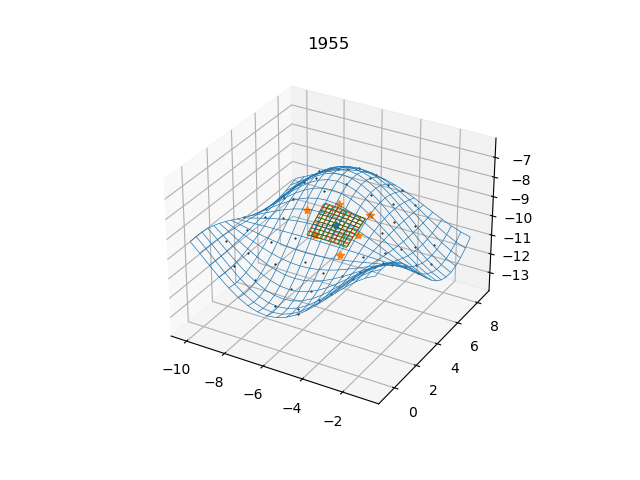

In [350]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
dist = ((v3.pos-v3.pos[i])**2).sum(axis=1)**0.5
in_dist = dist<5
x, y = np.linspace(tuple(v3.pos[in_dist,:2].min(axis=0)),tuple(v3.pos[in_dist,:2].max(axis=0)),20).T
X,Y = np.meshgrid(x,y)
Z = z0+r*np.cos(X/c0)*np.cos(Y/c0)
ax.plot_wireframe(X,Y,Z,linewidths=0.5)
X,Y,Z = square_comp(*v3.pos[i],v3.eigenvalue_0[i],v3.eigenvalue_1[i],v3.eigenvalue_2[i],v3.eig0[i],v3.eig1[i],v3.eig2[i])
ax.plot_wireframe(X,Y,Z,linewidths=0.5,color='g')
X,Y,Z = square_comp(*v3.pos[i],*mg.w,0,*mg.vxyz,mg.n)
ax.plot_wireframe(X,Y,Z,linewidths=0.5,color='r')
ax.plot(*v3.pos[in_dist].T,'.k',markersize=1)
ax.plot(*v3.pos[i],'*')
ax.plot(*v3.pos[v3.get_ordered_neighbors(v3.indices[i])].T,'*')
ax.set_aspect('equal')
ax.set_title(f'{i}')